# Coresests

## Intro
The notion of **coresets** originates from computational geometry and refers to data summarization with strong theoretical guarantees. Coresets are gaining attention in the machine learning community: they allow to run expensive algorithms on a small subset of the data with error guarantees - this feature makes them the preferred choice over randomly created subsamples of the data. 

In the standard learning setting, we fit a model that explains a given data set $\mathbf{X}=\{x_1,...,x_n\}$. For this, the model is parametrized by $Q$ (usually called *query* in the coreset literature) that belongs to a family of  parameters $\mathcal{Q}$. Then, a particular parameter is chosen such that it minimizes a cost function, i.e.:
$$\min_{Q \in \mathcal{Q}} \sum_{i=1}^n \textrm{cost}(x_i, Q).$$ 

When the dataset is large, then the optimization and the storage become very costly. The idea is to find a weighted subset of points of size $m \ll n$,  $\mathbf{C}=\{(c_1,w_1)...,(c_m, w_m)\}$ where $c_i$ are points from the data set and $w_i$ are their weights, such that the optimization problem now is performed on this new set $\mathbf{C}$:
$$\min_{Q \in \mathcal{Q}} \sum_{i=1}^m w_i \textrm{cost}(c_i, Q).$$

If the following holds for $\mathbf{C}$ with high probability, the following inequality holds: 
$$ \left| \sum_{i=1}^n \textrm{cost}(x_i, Q) -   \sum_{i=1}^m w_i \textrm{cost}(c_i, Q)\right| \leq \varepsilon  \sum_{i=1}^n \textrm{cost}(x_i, Q),\quad \forall Q \in \mathcal{Q}.$$ 
then we call $\mathbf{C}$ a coreset.
In words, the total cost evaluated on the coreset points is $\varepsilon$-multiplicatively close to the total cost evaluated at all points *uniformly* for all parameters (or queries). This means that we can solve the problem on the coreset without incurring too much error.

Let us consider a few examples. In k-Means the queries are the centers and the objective is the squared euclidean distance to the closest center, in a neural network for a classification task the queries are the weights and the cost the negative log-likelihood. The coreset property states that no matter what centers we choose for k-Means, or what weights we choose for neural nets, the total distance to the closest centers, respectively, the negative log likelihood calculated on the coreset are close to the true values. Importantly, this is also the case at the optimal parameters, which justifies the optimization on the coreset.

There are some aspects of coresets that we skipped in this short intro. For a lenghtier intro to coresets, please refer to:

>Bachem, O., Lucic, M., & Krause, A. (2017). 
>Practical coreset constructions for machine learning. 
>arXiv preprint arXiv:1703.06476.


Coresets are inherently problem specific and require two ingredients: constructing the weighted subsample and extending algorithms to handle the weighted data. In this tutorial, we will see how to create and use coresets for some basic models relying on the coreset library. 

## Coreset Library

The coreset library implements efficient coreset generation for
* k-Means
* Gaussian mixture models (GMM)
* Bayesian Gaussian mixture models (BGMM)
* Dirichlet process Gaussian mixture models (DPGMM)

and also provides the adapted version of these algorithms to support weighted data. This tutorial showcases the usage of the library and illustrates the principal techniques of working with coresets.

### References
The implementation of the library is based on the following works:
>Bachem, O., Lucic, M., & Krause, A. (2017). Practical coreset constructions for machine learning. arXiv preprint arXiv:1703.06476.

> Bachem, O., Lucic, M., & Krause, A. (2017). Scalable and distributed clustering via lightweight coresets. arXiv preprint arXiv:1702.08248.

>Lucic, M., Faulkner, M., Krause, A., & Feldman, D. (2018). Training Gaussian Mixture Models at Scale via Coresets. Journal of Machine Learning Research, 18, Art-No.

> Borsos, Z., Bachem, O., & Krause, A. Variational Inference for DPGMM with Coresets. (2017). Advances in Approximate Bayesian Inference

## Tutorial

### k-Means
In this part, we will look at applying coresets to k-Means. First, let us generate some data for clustering. We will do this with the [Chinese restaurant process](https://en.wikipedia.org/wiki/Chinese_restaurant_process).

In [33]:
from __future__ import division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
np.random.seed(42)
from utils import datagen, plotting
import coresets
import algorithms


In [34]:
n = 150
# X, true_k, assignment = datagen.crp(n=n, alpha=5)

We plot the generated dataset together with the cluster assignments.

In [35]:
import torch
import torch.nn as nn
import pickle

X = torch.tensor(np.stack(pickle.load(open( "/home/vm2656/aal_time_series_nyu_150_protocol_2.pkl", "rb")))).float()

In [36]:
X.size()

torch.Size([150, 176, 116])

In [37]:
X = torch.reshape(X,(26400,116))

In [38]:
X = X.numpy()

If we cluster the data with $k=10$ centers, we get the following result:

In [39]:
X = X.astype(float)
X[0].dtype

dtype('float64')

Total k-Means cost: 2810531.41666


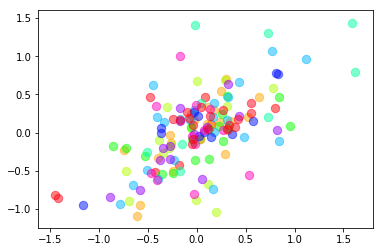

In [40]:
k = 10
km = algorithms.WeightedKMeans(n_clusters=k, n_iter=10)
km.fit(X)
y,dists = km.predict(X)
plotting.plot_2d_points_with_assignment(X, y)
print("Total k-Means cost: {}".format(np.sum(dists)))

In theory, the coresets gurantees hold for a specific subset size. In practice, we determine the coreset size based on the amount of data we are capable of working with. Suppose we can only afford to run k-Means on 1% of the original data. The first idea is to randomly subsample the data and fit k-Means on it.

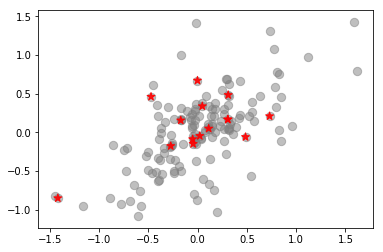

In [41]:
n = 150
coreset_size = int(n * 0.1)
uniform_coreset_gen = coresets.KMeansUniformCoreset(X)
C_u, w_u = uniform_coreset_gen.generate_coreset(coreset_size)
plotting.plot_2d_points_and_coreset(X, C_u, w_u)

The red stars indicate selected coreset points. Since we are selecting points randomly, we are not going to represent smaller clusters with high probability. Next, we will see that this issue is remedied by using coresets. 

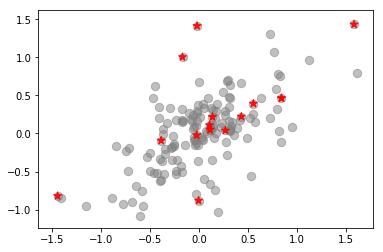

In [42]:
km_coreset_gen = coresets.KMeansCoreset(X)
C1, w1 = km_coreset_gen.generate_coreset(coreset_size)
plotting.plot_2d_points_and_coreset(X, C1, w1)

Ultimately, we are interested in the k-Means cost after fitting the model.

In [43]:
for C, w, name in [(X, np.ones(X.shape[0]), 'full data'), (C_u, w_u, 'uniform'), (C1, w1, 'coreset')]:
    km.fit(C, w)
    y, dists = km.predict(X)
    print("k-Means cost on {}: {}".format(name, np.sum(dists)))

k-Means cost on full data: 2809854.53547
k-Means cost on uniform: 3655718.90833
k-Means cost on coreset: 4214940.6382


Coresets produce convincing approximations to the full cost, even if they represent only 1% of the data. Uniform subsampling, on the other hand has a large margin of error.

### Computational costs

The default coreset generation method for k-Means, $\texttt{coresets.KMeansCoreset}$ relies on a $\texttt{k-means++}$ seeding step, which can be costly in itself, namely $\mathcal{O}(nkd)$, where $d$ is the dimension of the data - this is equivalent to 1 step of k-Means. Fortunately, there is a faster alternative to seeding:

>Fast and Provably Good Seedings for k-Means. Olivier Bachem, Mario Lucic, S. Hamed Hassani and Andreas Krause. To appear in Neural Information Processing Systems (NIPS), 2016.

The implementation is available at https://github.com/obachem/kmc2 and also in Tensorflow https://www.tensorflow.org/api_docs/python/tf/contrib/learn/KMeansClustering. 

We will illustrate is usage for coresets. In order to install the library, run:
>pip install kmc2

k-Means cost on coreset with kmc seeding: 3843412.7929


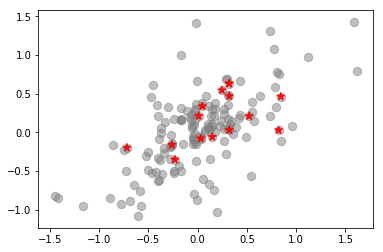

In [44]:
import kmc2
seeding = kmc2.kmc2(X, k)

km_coreset_gen_kmc = coresets.KMeansCoreset(X, init=seeding)
C2, w2 = km_coreset_gen_kmc.generate_coreset(coreset_size)
plotting.plot_2d_points_and_coreset(X, C2, w2)
km.fit(C2, w2)
y, dists = km.predict(X)
print("k-Means cost on coreset with kmc seeding: {}".format(np.sum(dists)))

### Streaming and distributed settings

Another advantage of coresets is that they can handle streaming and distributed data. This is possible due to the following two observations:
* merge: if $C_1$ is an $\varepsilon$-coreset of $X_1$ and $C_2$ is an $\varepsilon$-coreset of $X_2$, then $C_1 \cup C_2$ is an $\varepsilon$-coreset of $X_1 \cup X_2$
* compress: if $C$ is a $\varepsilon$-coreset of $X$ and $C'$ is a $\delta$-coreset of $C$, then $C'$ is a $(\varepsilon+\delta)$-coreset of $X$

Let us see this is practice. Suppose the data is split between two worker machines. Each of them can construct its own coreset and send it to the master that can merge them.

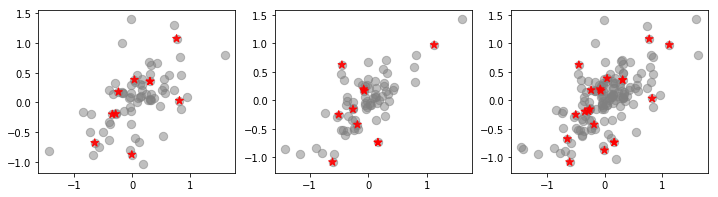

In [45]:
np.random.seed(0)
# n = 500
# X, true_k, assignment = datagen.crp(n=n, alpha=7)
coreset_size = 10
X1, X2 = X[:n//2], X[n//2:]
km_coreset_gen_1 = coresets.KMeansCoreset(X1)
km_coreset_gen_2 = coresets.KMeansCoreset(X2)
C1, w1 = km_coreset_gen_1.generate_coreset(coreset_size)
C2, w2 = km_coreset_gen_2.generate_coreset(coreset_size)

# merging is just stacking
C, w = np.vstack([C1, C2]), np.hstack([w1, w2])

plotting
plt.figure(figsize=(12, 3))
plt.subplot(131)
plotting.plot_2d_points_and_coreset(X1, C1, w1)
plt.subplot(132)
plotting.plot_2d_points_and_coreset(X2, C2, w2)
plt.subplot(133)
plotting.plot_2d_points_and_coreset(X, C, w)

In [46]:
km.fit(C,w)
y,dists = km.predict(X)
print(np.sum(dists))

3764004.1524306173


The streaming setting is a bit trickier. We simulate it by reading points one by one. We are only allowed to store the coreset and an additional buffer, where we store the recent points. When the buffer is full, we merge it with our existing coreset and compress it (in order to keep the fixed size).

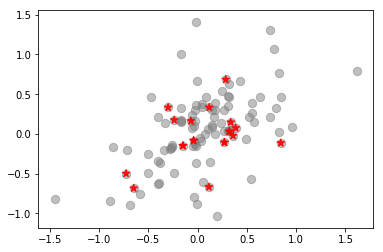

In [47]:
np.random.seed(0)
# n = 500
# X, true_k, assignment = datagen.crp(n=n, alpha=7)
coreset_size = 20
buffer_size = 100
buffer = []
C, w = None, None
for i, x in enumerate(X):
    buffer.append(x)
    if (i + 1) % buffer_size == 0:
        
        # merging
        X = np.array(buffer) if C is None else np.vstack([C, np.array(buffer)])
        weights = np.ones(buffer_size) if w is None else np.hstack([w, np.ones(buffer_size)])
        
        # compressing
        coreset_gen = coresets.KMeansCoreset(X, weights)
        C, w = coreset_gen.generate_coreset(coreset_size)
        
        # reset buffer
        buffer = []
plotting.plot_2d_points_and_coreset(X, C, w)

In [48]:
km.fit(C,w)
y,dists = km.predict(X)
print(np.sum(dists))

2328130.762308648


### Advanced Models

Now we will look at using coresets with a more advanced, the Bayesian Gaussian mixture model. For a nice presentation of these methods have a look [here](http://scikit-learn.org/stable/modules/mixture.html#pros-and-cons-of-variational-inference-with-bayesiangaussianmixture). As it turns out, it supports the same coreset constructions as k-Means (for details see the references). Again, we start by generating our dataset.

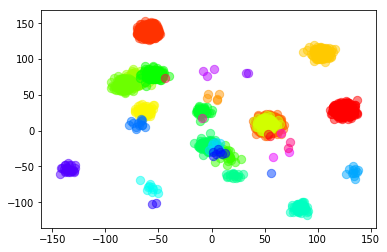

In [14]:
# np.random.seed(0)
# n = 5000
# X, true_k, assignment = datagen.crp(n=n, alpha=5)
# plotting.plot_2d_points_with_assignment(X, assignment)

We generate again a coreset of size 1% of the original data and fit the model to it.

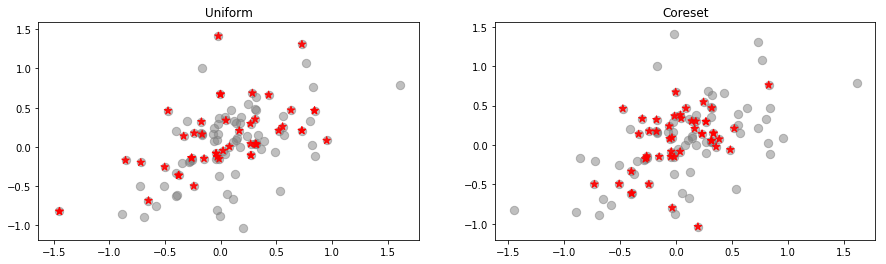

In [31]:
coreset_size = 50

uniform_gen = coresets.KMeansUniformCoreset(X)
C_u, w_u = uniform_gen.generate_coreset(coreset_size)

coreset_gen = coresets.KMeansCoreset(X, n_clusters=10)
C, w = coreset_gen.generate_coreset(coreset_size)

plt.figure(figsize=(15, 4))
for i, (data, weights, title) in enumerate([(C_u, w_u, "Uniform"), (C, w, "Coreset")]):
    plt.subplot(1, 2, i+1)
    plotting.plot_2d_points_and_coreset(X, data, weights)
    plt.title(title)

In [54]:
n_components = 10
plt.figure(figsize=(17, 4))
for i, (data, weights, title) in enumerate([(X, np.ones(X.shape[0]), 'Full data'),  (C_u, w_u, 'Uniform'), (C, w, 'Coreset')]):
    wbgm = algorithms.WeightedBayesianGaussianMixture(n_components=n_components, max_iter=500, reg_covar=0, init_params='kmeans')
    wbgm.fit(data, weights)
    ax1 = plt.subplot(1, 3, i+1)
    assignment = wbgm.predict(X)
    plotting.plot_2d_points_with_assignment(X, assignment)
    plotting.plot_ellipses(ax1, wbgm.weights_, wbgm.means_, wbgm.covariances_)
    plt.title("BGMM on {}".format(title))

MemoryError: 

<Figure size 1224x288 with 0 Axes>

As in the case of k-Means, we can observe the benefit of coresets. Since more diverse mixture components are discovered with coresets, it allows for better posterior approximation.